In [1]:
%%capture
!pip install torch==2.0.0 torchvision==0.15.1
!pip install d2l==1.0.3

# d2l - Chapter 10

## Section 10.6

In [2]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        # At its core, super() in Python returns a temporary object of the superclass that allows 
        # access to its methods. This feature is especially useful in inheritance and when overriding 
        # methods in the subclass.
        super().__init__()
    
    def forward(self, X, *args):
        raise NotImplementedError
    
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
    
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError
    
    def forward(self, X, state):
        raise NotImplementedError
    

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, enc_X, dec_X, *args):
        """
        """ 
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        return self.decoder(dec_X, dec_state)
        


## Section 10.7

In [4]:
def init_seq2seq(module):
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(Encoder):
    def __init__(
        self,
        vocab_size, embed_size,  # To create an embedding for each token in the input sequence
        num_hiddens, num_layers,
        dropout=0):
        """
            model = Seq2SeqEncoder(10,10,10,1)
            
            for module in model.modules():
            
                if type(module) == nn.GRU:
                    print(f'Type: {type(module)}')
            
                    for param in module._flat_weights_names:
                        print(param)
                        print(module._parameters[param])
        """

        super().__init__()
        # The nn.Embedding layer creates a lookup table where every word in your vocabulary 
        # is mapped to a vector of floating-point numbers.
        #   + During Initialization: It starts with random vectors.
        #   + During Training: The model adjusts the values in these vectors so that words with 
        #     similar meanings end up with similar vectors (i.e., close to each other in the vector space).
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(
            embed_size, 
            num_hiddens,
            num_layers,
            dropout
        )
        self.apply(init_seq2seq)
        # nn.Module.apply(fn)
        # https://stackoverflow.com/questions/55613518/how-does-the-applyfn-function-in-pytorch-work-with-a-function-without-return-s

    def forward(self, X, *args):  
        """
          forward() is inherited from d2l.Encoder. The base class has __call__ implented
          which runs forward() in it.
        """        
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))

# Why does this run forward?
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
        

d2l.Decoder:

```
class Decoder(nn.Module):
    """The base decoder interface for the encoder--decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
[docs]    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError


[docs]    def forward(self, X, state):
        raise NotImplementedError
```

In [5]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        # A torch.nn.Linear module where in_features is inferred.
        self.dense = nn.LazyLinear(out_features=vocab_size)

    def init_state(self, enc_all_outputs, *args):
        """
        The init_state method is responsible for taking the encoder's full results (enc_all_outputs) and 
        _formatting them correctly_ so that the decoder's forward method can immediately extract:
          + The necessary context vector (from enc_output[-1]).
          + The initial hidden state (hidden_state) for the decoder's RNN.
          
        Args:
            enc_all_outputs: contains the full set of outputs [= entire sequence of hidden states] 
            from the decoder's RNN {h_t}, t=1,...,T and the final hidden state {h_T} 
        """
        return enc_all_outputs

    def forward(self, X, state):
        """
        Args:
            X: input sequence provided to the decoder (target sequence tokens).
                 + During training, X is usually the ground-truth target sequence provided all at one.
                 + During generation | inference: The decoder is typically run one step at a time. In this case,
                   X would be contain only the token that was generated in the previous step.
                   NOTE: For a recurrent unit like a GRU, we only need the current token's embedding to calculate the next state.

            state: This is the internal hidden state (h) of the decoder's own recurrent unit.
        """
        embs = self.embedding(X.t().type(torch.int32))  # X = y_{t-1}
        enc_outputs, hidden_state = state                # {h_k}, where t=k, ... K   |   decoder's hidden state s_t

        context = enc_outputs[-1]                        # h_K

        # That line, context = context.repeat(embs.shape[0], 1, 1), is required for broadcasting the single 
        # context vector across all time steps of the input sequence so it can be concatenated with the decoder's word embeddings.
        # The goal is to ensure that the encoder's final summary of the input is available to the decoder's recurrent unit 
        # at every time step.
        context = context.repeat(embs.shape[0],1,1)

        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        # outputs: Tensor that represents the hidden state at _every single timpe step_ in the sequence you
        #          processed. => Used to generate your word prediction
        # hidden_state: The hidden state for the very last time step. 
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)

        return outputs, [enc_outputs, hidden_state]

In [6]:
# Check encoder
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

# Check decoder
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [48]:
# Putting it all together
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)

        # https://d2l.ai/chapter_linear-regression/oo-design.html#sec-oo-design
        self.save_hyperparameters()

    def validation_step(self, batch):  # NEXT: <=== Understrand
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()


In [50]:
class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""

    def _preprocess(self, text):
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')
        # Insert space between words and punctuation marks
        no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
        out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
               for i, char in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        return src, tgt
    
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    """
    Args:
        num_steps: Each sequence in a minibatch has the same length given by num_steps (number
                   of time steps or tokens)
        num_train: number of training examples
        num_val: number of validation examples
    """
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())

@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)



Layers in GRU:

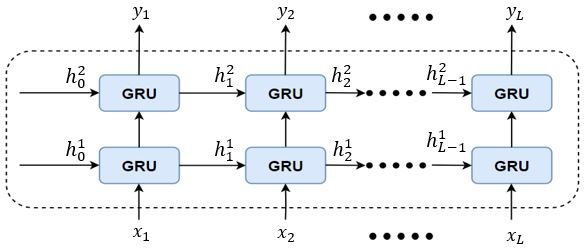![image.png]

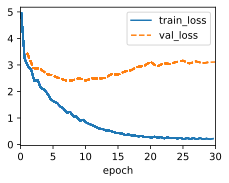

In [52]:
# https://d2l.ai/chapter_linear-regression/synthetic-regression-data.html#sec-synthetic-regression-data
# https://www.manythings.org/anki/
data = d2l.MTFraEng(batch_size=128)

# GRU(embed_size, num_hiddens, num_layers, dropout)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


In [ ]:
# Prediction

Remember for a vanilla RNN:

Decoder: $s_{t+1} = \text{thanh}(
W_y y_t + W_c c + W_s s_t
)$, where the context from the _encoder_ is given by $c = g(h_1, ..., h_K)$

Then, to predict:

$p(y_{t+1} | y_1, ... y_t, c) = \text{softmax}(
W_o g(
y_t, c, s_t
)
)$

In [61]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

In [73]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

# Section 10.5
src, tgt, src_valid_len, label =  data.build(engs, fras)

In [80]:
src.shape, tgt.shape, src_valid_len.shape, label.shape

print(src[0])
print(tgt[0])
print(src_valid_len)
print(label[0])

tensor([59,  2,  3,  4,  4,  4,  4,  4,  4])
tensor([  3, 201,   0,   4,   5,   5,   5,   5,   5])
tensor([3, 4, 4, 4])
tensor([201,   0,   4,   5,   5,   5,   5,   5,   5])
